# BIOMASS PRODUCT COMPARISON : COUNTRY SUMMARY for CAMBODIA ### 

#### CODE PREPARED BY:
#### Neha Hunka, University of Maryland
#### Veronika Leitold, University of Maryland
#### David Minor, University of Maryland

#### LOAD PACKAGES ###

In [1]:
packages <- c("viridis","ggplot2","tidyr","terra", "sf", "rgeos", "geosphere","RColorBrewer","jpeg","plyr","maptools", "scales","dplyr")
package.check <- lapply(packages, FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
        install.packages(x, dependencies = TRUE)
        library(x, character.only = TRUE, quietly=TRUE)
    }
})
Sys.setenv("AWS_DEFAULT_REGION" = 'us-west-2')

Loading required package: viridis

Loading required package: viridisLite

Loading required package: ggplot2

Loading required package: tidyr

Loading required package: terra

terra 1.7.29


Attaching package: ‘terra’


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: sf

Linking to GEOS 3.11.2, GDAL 3.7.0, PROJ 9.2.0; sf_use_s2() is TRUE

Loading required package: rgeos

Loading required package: sp

rgeos version: 0.6-3, (SVN revision 696)
 GEOS runtime version: 3.11.2-CAPI-1.17.2 
 Please note that rgeos will be retired during October 2023,
plan transition to sf or terra functions using GEOS at your earliest convenience.
See https://r-spatial.org/r/2023/05/15/evolution4.html for details.
 GEOS using OverlayNG
 Linking to sp version: 1.6-1 
 Polygon checking: TRUE 


Loading required package: geosphere

Loading required package: RColorBrewer

Loading required package: jpeg

Loading required package: plyr

Loading required package: maptools


#### LINK TO PRE-DEFINED FUNCTIONS ###

In [2]:
source_link <-'/projects/ADE_biomass_harmonization/NASA_CMS/NASA_CMS_2023/Cambodia/Country_summaries_functions.R'
source(source_link)

#### LIST OF AVAILABLE COUNTRY BOUNDARIES ###

In [16]:
# Cont <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/CAMBODIA/SrepokWildlifeSanctuary.gpkg")
Cont <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/Mongolia_extent_buff.gpkg")
Country_list <- Cont
Country_list["ID"] <- 1
Country_list["Continent"] <- "Asia"
Country_list["Country"] <- 'Mongolia'
Country_list["Evaluate"] <- "Yes"
Country_list["Eval_ISB"] <- "No"
Country_list["ne_10m_a_1"] <- "MNG"
Country_list["CODE"] <- "MNG"
Country_list["ADM0_A3"] <- "MNG"
Cont <- Country_list

### BIG COUNTRIES SPLIT #######
BIG_countries <- FALSE

Reading layer `output' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/Mongolia_extent_buff.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 168 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 87.63648 ymin: 41.48658 xmax: 120.0068 ymax: 52.22955
Geodetic CRS:  WGS 84


#### LIST OF AVAILABLE WWF Biome BOUNDARIES ###

In [4]:
biomes <- st_read("/projects/shared-buckets/leitoldv/WWF_biomes/wwf_terr_ecos.shp")
biomes_key <- read.csv("/projects/shared-buckets/leitoldv/WWF_biomes/wwf_biomes_key.csv")

Reading layer `wwf_terr_ecos' from data source 
  `/projects/shared-buckets/leitoldv/WWF_biomes/wwf_terr_ecos.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 14351 features and 22 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -180 ymin: -87.26008 xmax: 180 ymax: 83.62313
Geodetic CRS:  WGS 84


###  -------------------------------------------------------------------------------------------------------
###  !!!!!!!!! DATA AND ANALYSIS QUESTIONAIRE FOR USER (fill in before executing script) !!!!!!! ### 
###  -------------------------------------------------------------------------------------------------------

##### Set the country code for which biomass comparison is to be done (if unsure, see above list) 

In [17]:
iso3 <- c("MNG") # c("PRY") 

In [18]:
Base_folder = '/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/' 

################# Create necessary subfolders for outputs #####################################
if (!dir.exists(Base_folder)){dir.create(Base_folder)}
Out_folder = file.path(Base_folder,iso3)
if (!dir.exists(Out_folder)){dir.create(Out_folder)}
if (dir.exists(Out_folder)){dir.create(file.path(Out_folder,paste0(iso3,'_Product_Comparisons')))}
if (dir.exists(Out_folder)){dir.create(file.path(Out_folder,paste0(iso3,'_Product_AOI')))}
if (dir.exists(Out_folder)){dir.create(file.path(Out_folder,paste0(iso3,'_Product_FMASK')))}

##### Set the maps that need to be compared and the versions/date

In [19]:
maps <- c('CCI','GEDI') # List the maps for which a comparison is to be done ,'NCEO','JPL'

################# Exception if country not in Africa ########################################
if (is.element('NCEO', maps) & !Country_list$Continent[Country_list$CODE == iso3] == 'Africa'){
    print('NOTE : Country is not in Africa - NCEO will be removed') 
    maps = maps[maps != 'NCEO']
    } 
if (Country_list$Eval_ISB[Country_list$CODE == iso3] == 'N') {maps = maps[maps != 'ISB']}
if (is.element('ISB', maps) & dir.exists(Out_folder)){
    dir.create(file.path(Out_folder,paste0(iso3,'_Product_ISB')))
    isb_folder <- file.path(Out_folder,paste0(iso3,'_Product_ISB'))
}

##### Set the years and versions of the biomass maps to be used 

In [20]:
if (is.element('CCI', maps)){CCI_year = '2020'
                             CCI_version = 4}
if (is.element('JPL', maps)){JPL_year = '2020'}
if (is.element('GEDI', maps)){GEDI_year = '2020'}
if (is.element('NCEO', maps)){NCEO_year = '2017'}
if (is.element('ISB', maps)){ISB_year = '2020'}
if (is.element('MEX_AGB', maps)){MEX_AGB_year = '2020'}

##### Set source folders of biomass maps - needs to be improved, all maps should be in one location? 

In [21]:
# if (is.element('CCI', maps)){cci_folder <- paste0("/projects/my-public-bucket/Data/Biomass_maps/CCI_2018/dap.ceda.ac.uk/neodc/esacci/biomass/data/agb/maps/v3.0/geotiff")}
if (is.element('CCI', maps)){cci_folder <- paste0('/projects/my-private-bucket/Data/CCI_2020')}
if (is.element('JPL', maps)){jpl_folder <- "/projects/shared-buckets/alanxuliang/AGB_2020_latest"}
if (is.element('JPL', maps) & (iso3=="BGD" | iso3=='IND' | iso3=='MMR' | iso3=='KHM' | iso3=='LAO' | iso3=='LKA' | iso3=='THA' | iso3=='VNM')){jpl_folder <- "/projects/my-public-bucket/Data/Biomass_maps/JPL2020"}
if (is.element('JPL', maps) & (iso3=="CN053" | iso3=='CN081' | iso3=='CN082' | iso3=='CN045' | iso3=='CN044' | iso3=='CN046' | iso3=='CN071')){jpl_folder <- "/projects/my-public-bucket/Data/Biomass_maps/JPL2020"}
if (is.element('GEDI', maps)){gedi_folder <- "/projects/my-public-bucket/Data/Biomass_maps/GEDI_L4B_v21"}
if (is.element('NCEO', maps)){nceo_folder <- "/projects/shared-buckets/minord/data/nceo_africa_biomass/clipped"}
if (is.element('MEX_AGB', maps)){nceo_folder <- "/projects/my-public-bucket/Data/Biomass_maps/MEX_NFI_AGB/Biomasa_mosaico_por_formacion_WGS84.tif"}

##### Set how forest/non-forest areas should be treated 
#####  - (External = An external datasource (e.g. Hansen, ALOS, Sentinel, or country-provided map) is used to mask out pixels in all maps)
#####  - (None = no forest mask is applied, maps are treated just as they are provided)

In [22]:
forest_mask <- c('None') # c('External') or c('None') 
if (forest_mask == c('None')) {Default_FMASK = FALSE}
if (forest_mask == c('External')) {
    Default_FMASK = TRUE #set to true if no external mask is available. Default uses 2020 Hansen Tree Cover in units of %. 
    if (Default_FMASK){
        print("Hansen 2020 tree cover % to be used as an FMASK")
        EMask_folder <- "/projects/shared-buckets/leitoldv/gfc_data" # Source folder for original Hansen 2020 TC maps 
        HOut_folder <- "/projects/my-public-bucket/Biomass_Harmonization_OUTPUTS/HANSEN_TC2020" # Output folder for processed Hansen 2020 TC maps 
        if (!dir.exists(HOut_folder)){dir.create(HOut_folder)}
        EMask_file <- paste0("HANSEN_TC2020_",iso3,".tif") # Name of output file for Hansen 2020 TC map for country of interest  
        non_forest_value <- 10
        resample_method <- "bilinear" 
    }
    if (!Default_FMASK){
        print("External FMASK is provided by user")
        print(paste("Please refer to",source_link,"to adjust for parameters of the countr-specific forest mask"))
    }
}

### GENERATE A GRID FOR CCI AND HANSEN LAYERS (do not remove even if CCI and HANSEN are not used)  

In [23]:
comparison_grid <- c('CCI')
Grid_tiles <- Grid_set(maps=comparison_grid)

###  -------------------------------------------------------------------------------------------------------
###  !!!!!!!!! START ANALYSIS !!!!!!! ### 
###  -------------------------------------------------------------------------------------------------------

### DISPLAY COUNTRY OF INTEREST AND TILES 

Writing layer `MNG_aoi' to data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA//MNG' using driver `ESRI Shapefile'


Warning message in CPL_write_ogr(obj, dsn, layer, driver, as.character(dataset_options), :
“GDAL Message 6: Normalized/laundered field name: 'Continent' to 'Continen_1'”


Writing 1 features with 175 fields and geometry type Multi Polygon.


Warning message in CPL_write_ogr(obj, dsn, layer, driver, as.character(dataset_options), :
“GDAL Message 1: Value 1159321071 of field NE_ID of feature 0 not successfully written. Possibly due to too larger number with respect to field width”
Warning message in CPL_write_ogr(obj, dsn, layer, driver, as.character(dataset_options), :
“GDAL Message 1: One or several characters couldn't be converted correctly from UTF-8 to ISO-8859-1.  This warning will not be emitted anymore.”
Warning message in plot.sf(aoi, col = "red", add = T):
“ignoring all but the first attribute”


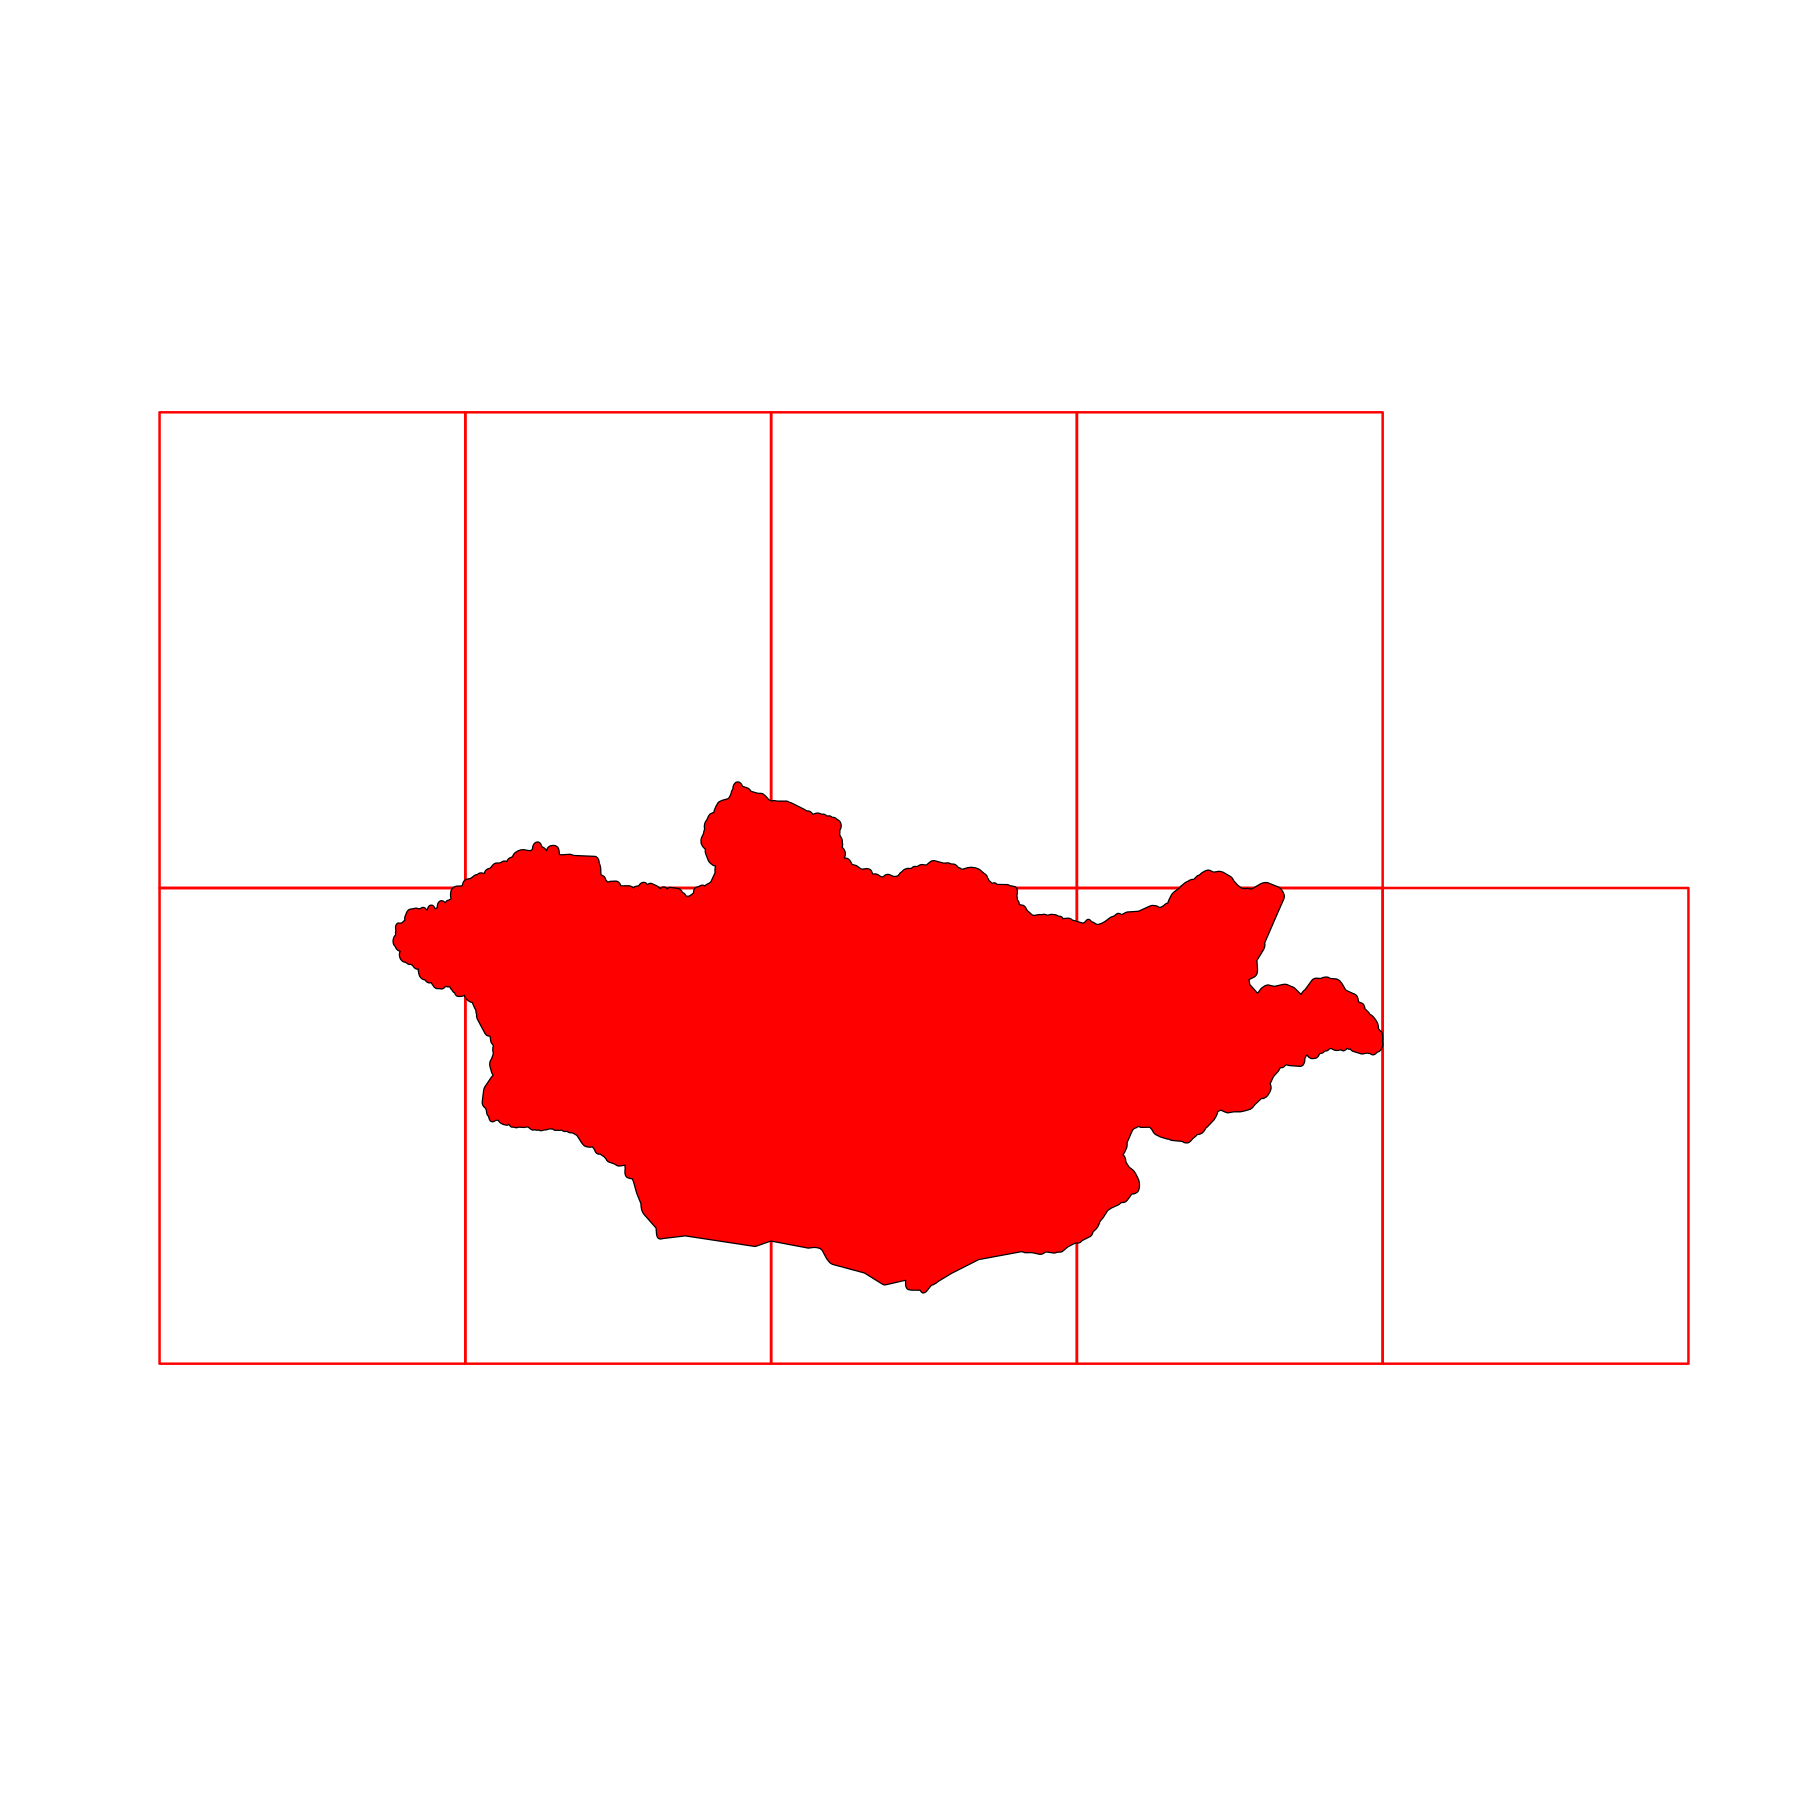

In [24]:
# Cont <- Cont[Cont$CONTINENT==Country_list$Continent[Country_list$CODE == iso3],]
Cont$ADM0_A3 <- Country_list$CODE
conti <- Country_list$Continent[Country_list$CODE == iso3]
aoi <- Cont[Cont$ADM0_A3 == iso3,]
AOI_file = file.path(Out_folder,paste0(iso3,'_aoi.shp'))
if (!file.exists(AOI_file)) {st_write(obj=aoi, dsn=Out_folder, layer=paste0(iso3,'_aoi'), driver="ESRI Shapefile")}
if (!identical(st_crs(aoi), st_crs(Grid_tiles))){aoi <- aoi %>% st_transform(st_crs(Grid_tiles))}

intersecting <- (st_intersects(st_as_sf(aoi),st_as_sf(Grid_tiles)))[[1]]
nrow_tiles <- intersecting
if (length(intersecting) == 0) {
    stop('no intersecting CCI Biomass tiles found')
} else {tiles <- (Grid_tiles[nrow_tiles,])}

aoi <- aoi %>% st_transform(st_crs(tiles)) # Transform aoi to match tiles CRS so it can be used later for cropping
plot(tiles, lwd=2, border="red")
plot(aoi, col="red", add=T)

### READ BIOMASS MAPS, PREPARE AOI_MASKED DATA AND PLOTS

##### (original maps and histograms, no resampling done here!)

[1] "CCI"
[1] "list"
[1] "GEDI"


Warning message in plot.sf(aoi, add = T, col = NA, border = "black"):
“ignoring all but the first attribute”
Warning message in plot.sf(aoi, add = T, col = NA, border = "black"):
“ignoring all but the first attribute”


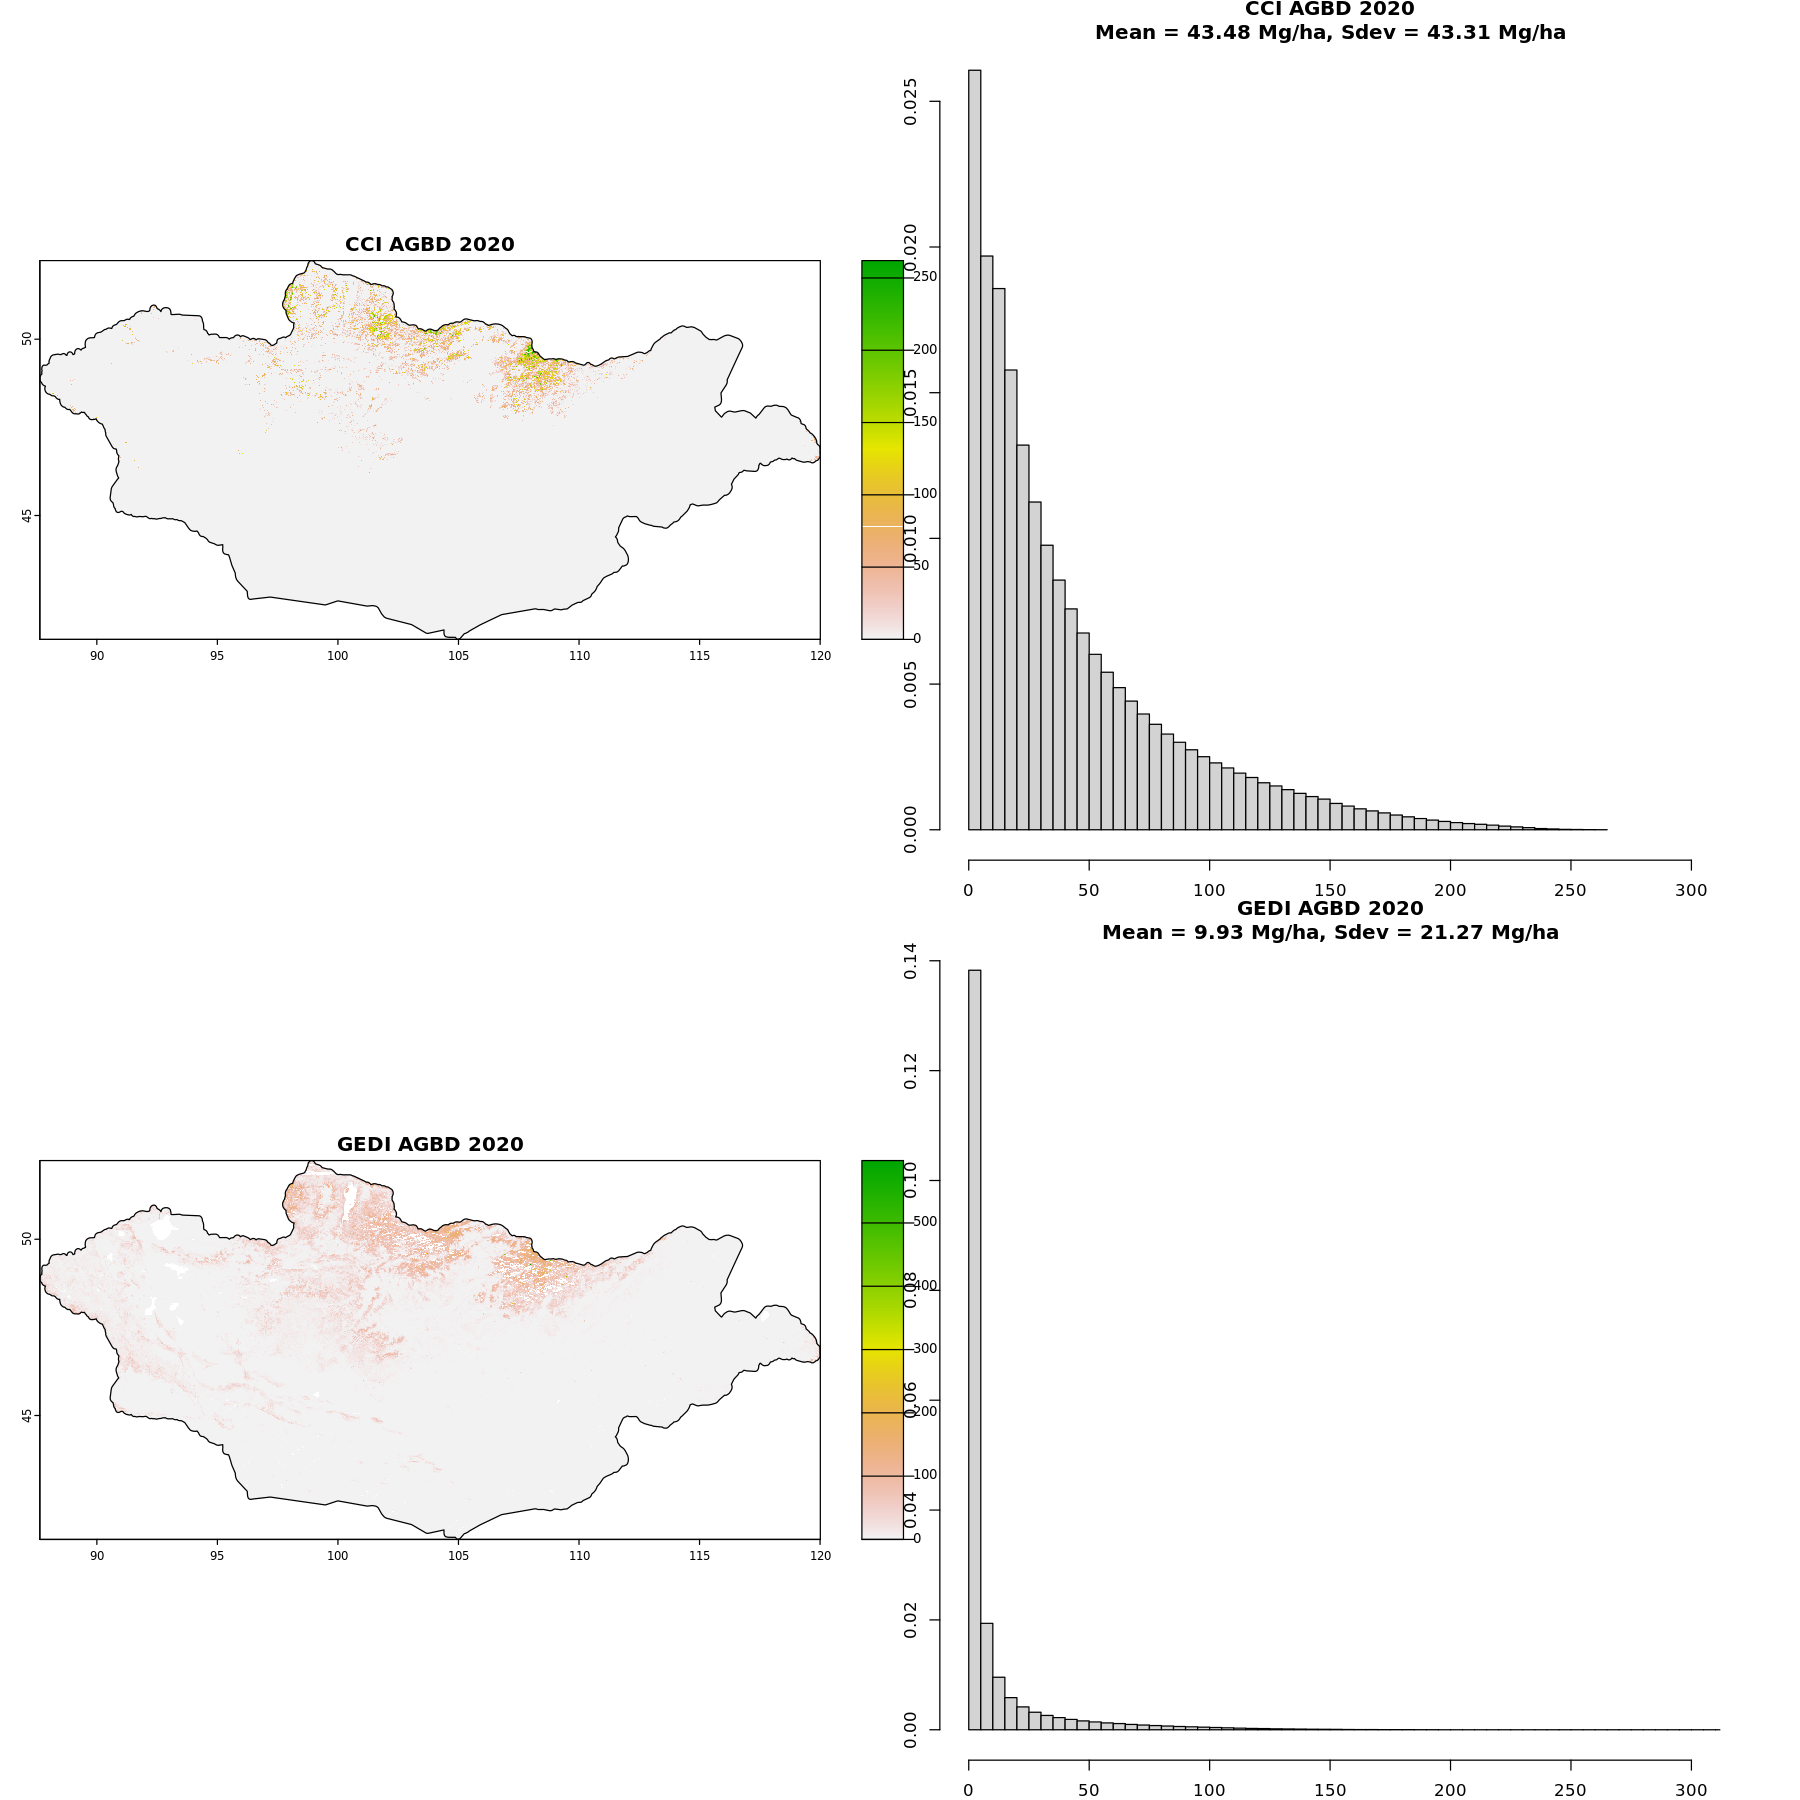

In [25]:
Link_maps_AOImasked <- ''
maps_AOImasked <- ''
for (i in 1:length(maps)){
    print(maps[i])
    assign((text = tolower(maps[i])),readAGBmap(AOI_file=AOI_file,aoi=aoi,continent=conti,map=maps[i],In_folder=eval(parse(text=paste0(tolower(maps[i]),'_folder'))),In_year = eval(parse(text=paste0(maps[i],'_year'))),cci_version=CCI_version,Out_folder=Out_folder))
    maps_AOImasked[[length(maps_AOImasked) + 1]] <- paste0(tolower(maps[i]),"_AOImasked")
    Link_maps_AOImasked[[length(Link_maps_AOImasked) + 1]] <- file.path(Out_folder,paste0(iso3,'_Product_AOI'),paste0(maps[i],"_AOImasked.tif"))
    assign((text = paste0(tolower(maps[i]),"_AOImasked")),(mask(eval(parse(text=tolower(maps[i]))), aoi, updatevalue=NA)))
    # if (maps[i]=='JPL'){
    #     if (length(eval(parse(text="jpl_AOImasked"))) < 0.9*length(eval(parse(text="cci_AOImasked")))){
    #         print("The JPL map is WRONG: It is corrupt or much smaller than expected...redoing...")
    #         assign((text = paste0(tolower(maps[i]),"_AOImasked")),fixJPLfile(aoi=aoi))
    #     }
    # }
    corrected_values <- eval(parse(text=paste0(tolower(maps[i]),"_AOImasked")))
    corrected_values[corrected_values<0]=0
    assign((text = paste0(tolower(maps[i]),"_AOImasked")),corrected_values)
    assign((names(eval(parse(text=paste0(tolower(maps[i]),"_AOImasked"))))), c(paste0("agbd_",paste0(maps[i],"_year"))))
    writeRaster(eval(parse(text=paste0(tolower(maps[i]),"_AOImasked"))),file.path(Out_folder,paste0(iso3,'_Product_AOI'),paste0(maps[i],"_AOImasked.tif")), overwrite=TRUE)
    rm(list = c("corrected_values"))
    rm(list = c(tolower(maps[i])))
}
maps_AOImasked <- maps_AOImasked[maps_AOImasked != ""]
Link_maps_AOImasked <- Link_maps_AOImasked[Link_maps_AOImasked != ""]

par(mfrow=c(length(maps),2), mar=c(2,2,1,1))
options(repr.plot.width=15, repr.plot.height=15)
Save_Perc999 <- Percentile_xlim(maps=maps) 
for (i in 1:length(maps)){
    plot(eval(parse(text=paste0(tolower(maps[i]),"_AOImasked"))), main=paste0(maps[i]," AGBD ", eval(parse(text=paste0(maps[i],"_year")))), zlim=c(0,Save_Perc999),cex.lab=2, cex.axis=2)
    plot(aoi, add=T,col=NA,border="black")
    map_values <- values(eval(parse(text=paste0(tolower(maps[i]),"_AOImasked"))))
    map_values <- map_values[map_values > 0]
    assign((text = paste0(tolower(maps[i]),"_AOImeans")),round(mean(map_values, na.rm=TRUE),2))
    for_n_count <- eval(parse(text=paste0(tolower(maps[i]),"_AOImasked")))
    if (BIG_countries == TRUE) {assign((text = paste0(tolower(maps[i]),"_AOImeans_ncount")),length(for_n_count[for_n_count>0]))}
    if (!all(is.na(map_values))) {
        hist(map_values, freq=F,breaks=seq(0,round(max(map_values,na.rm=T),digits=-1)+5,5),main=paste0(maps[i]," AGBD ", eval(parse(text=paste0(maps[i],"_year"))),'\n',paste("Mean = ",round(mean(map_values, na.rm=TRUE),2),sep=""),paste(" Mg/ha, Sdev = ",round(sd(map_values, na.rm=TRUE),2)," Mg/ha",sep="")),cex.lab=1, cex.axis=1, xlab="Aboveground biomass [Mg/Ha]", xlim=c(0,Save_Perc999+50))#, ylim=c(0,0.025)
    } else {plot(NULL, xlim=c(0,1), ylim=c(0,1), ylab="y label", xlab="x lablel",main=paste0(maps[i]," AGBD ", eval(parse(text=paste0(maps[i],"_year"))),": No values"))}
    rm(list = c("map_values","for_n_count"))
}

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_density()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_density()`).”


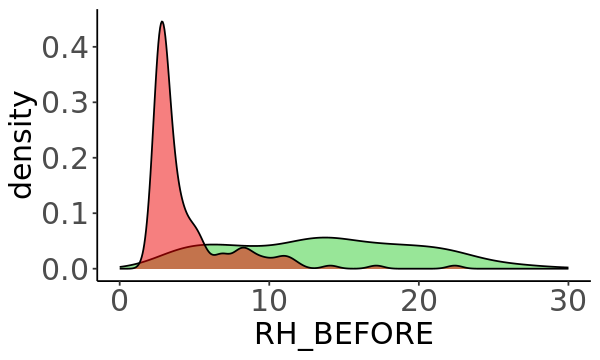

In [7]:
options(repr.plot.width=5, repr.plot.height=3)

TAB <- read.csv("/projects/ADE_biomass_harmonization/SERVIR/Belize_L2A_as_excel.csv")
TAB <- read.csv("/projects/ADE_biomass_harmonization/SERVIR/BEL_def_before_csv.csv")
RH_BEFORE <- TAB$rh98#[1:807]
TAB <- read.csv("/projects/ADE_biomass_harmonization/SERVIR/BEL_def_after_csv.csv")
RH_AFTER <- TAB$rh98#[1139:1534]
line_col=c("green","red2")

p <- ggplot() + 
# ggtitle(T) +
geom_density(aes(x=RH_BEFORE),fill=c("limegreen"),alpha=0.5) +
geom_density(aes(x=RH_AFTER),fill=c("red2"),alpha=0.5) +
theme_bw() + 
xlim(0,30) +
ylab("Density") +
xlab("NASA GEDI RH98 metric [m]") + 
theme(
    panel.grid = element_blank(),
    axis.line = element_line(colour = "black"),
    panel.border = element_blank(),
    axis.text.y=element_text(size=18),
    axis.text.x=element_text(size=18),
    legend.position="none",
    axis.title.y=element_text(size=18),
    axis.title.x=element_text(size=18),
    plot.title = element_text(size=18,hjust = 0.5)
)
print(p)
ggsave(p, file=paste0("/projects/ADE_biomass_harmonization/SERVIR/HIST.png"), width=5, height=5)